In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
%matplotlib inline
import sys
import os
from scipy.optimize import newton, minimize, fsolve
import numpy as np
import copy
import re

import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib import rc

import random
import isocor

In [2]:
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

In [3]:
palette = sns.color_palette(as_cmap=True)
palette.extend(['salmon', 'teal','yellowgreen'])

In [4]:
sns.color_palette(palette)

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215),
 (0.9803921568627451, 0.5019607843137255, 0.4470588235294118),
 (0.0, 0.5019607843137255, 0.5019607843137255),
 (0.6039215686274509, 0.803921568627451, 0.19607843137254902)]

In [5]:
element_prob_dict = {
    'C_natural-U13C-Glc-Gln': 1-0.99401515,
    'C_enriched-U13C-Glc-Gln': 0.99401515,
    'C_natural-13C2-Asp': 1-0.99401515,
    'C_enriched-13C2-Asp': 0.99401515,
}

In [6]:
metab_to_correct = {
    'Aspartate': {
        'ion_formula': 'C4H6NO4',
        'tracer_element': '13C',
        'charge': -1
    },
    'Carbamoylaspartate': {
        'ion_formula': 'C5H7N2O5',
        'tracer_element': '13C',
        'charge': -1
    },
    'Cis-aconitate': {
        'ion_formula': 'C6H5O6',
        'tracer_element': '13C',
        'charge': -1
    },
    'Fumarate': {
        'ion_formula': 'C4H3O4',
        'tracer_element': '13C',
        'charge': -1
    },
    'Malate': {
        'ion_formula': 'C4H5O5',
        'tracer_element': '13C',
        'charge': -1
    },
    'alpha-Ketoglutarate': {
        'ion_formula': 'C5H5O5',
        'tracer_element': '13C',
        'charge': -1
    },
    'Glutamate': {
        'ion_formula': 'C5H8NO4',
        'tracer_element': '13C',
        'charge': -1
    },
    'Glycerol-3-phosphate': {
        'ion_formula': 'C3H8O6P',
        'tracer_element': '13C',
        'charge': -1
    },
    'Glucose': {
        'ion_formula': 'C6H11O6',
        'tracer_element': '13C',
        'charge': -1
    },
    'Glucose-6-phosphate': {
        'ion_formula': 'C6H12O9P',
        'tracer_element': '13C',
        'charge': -1
    },
    
    
    'Glutamine': {
        'ion_formula': 'C5H11N2O3',
        'tracer_element': '13C',
        'charge': 1
    },
    'Asparagine': {
        'ion_formula': 'C4H9N2O3',
        'tracer_element': '13C',
        'charge': 1
    },
    'UMP': {
        'ion_formula': 'C9H12N2O9P',
        'tracer_element': '13C',
        'charge': -1
    },
    'CMP': {
        'ion_formula': 'C9H13N3O8P',
        'tracer_element': '13C',
        'charge': -1
    }
}

In [7]:
annotation_df = pd.read_excel('annotations.xlsx')

In [8]:
### Read measurements

### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('Asp_Glc-Gln_tracing.xlsx', sheet_name=None)

metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        sp = k[:-4].split()
        if len(sp) == 2:
            base, isotope = sp
        else:
            base, isotope = [sp[0], '13C0']
        
        metab_names_mes.append(base)
        
        df_tmp = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
        # df_tmp['Sample_name'] = df_tmp['Sample ID']
        df_tmp['Sample_name'] = [fn.split('_')[-1] for fn in df_tmp['Filename']]
        df_tmp['Compound'] = base
        df_tmp['Isotope'] = isotope
        df_tmp['Isotope_order'] = isotope[3:]
        # Placeholder
        df_tmp['Isotope_fraction'] = 0
        
        # Add annotations:
        df_tmp = df_tmp.merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        df_tmp = df_tmp.drop(['Type', 'Filename', 'Flag Details', 'Sample ID'], axis=1)
        
        if base in metab_dict_mes:
            metab_dict_mes[base] = metab_dict_mes[base].append(df_tmp)
        else:
            metab_dict_mes[base] = copy.deepcopy(df_tmp)

In [9]:
for base in set(metab_names_mes):
    metab_dict_mes[base] = metab_dict_mes[base].sort_values(by=['Isotope_order', 'Sample_name'])
    for sn in set(metab_dict_mes[base]['Sample_name'].values):
        sn_mask = metab_dict_mes[base]['Sample_name'] == sn
        base = metab_dict_mes[base].loc[sn_mask, 'Compound'].values[0]
        tracer = metab_dict_mes[base].loc[sn_mask, 'Tracer'].values[0]
        obs_mid = metab_dict_mes[base].loc[sn_mask, 'Response'].values

        ion_formula = metab_to_correct[base]['ion_formula']
        charge = metab_to_correct[base]['charge']
        tracer_element = metab_to_correct[base]['tracer_element']
        tracer_purity = [element_prob_dict['C_natural-{}'.format(tracer)], element_prob_dict['C_enriched-{}'.format(tracer)]]

        corrector_HR = isocor.mscorrectors.MetaboliteCorrectorFactory(formula=ion_formula, label=base, tracer=tracer_element, tracer_purity=tracer_purity, resolution=240000, mz_of_resolution=200, charge=charge, correct_NA_tracer=True, resolution_formula_code='orbitrap')

        # Calculate the corrected isotope fraction:
        corrected_area, iso_fraction, res, m_enr = corrector_HR.correct(obs_mid)
        metab_dict_mes[base].loc[sn_mask, 'Isotope_fraction'] = iso_fraction
        metab_dict_mes[base]= metab_dict_mes[base].fillna(0)
    

In [10]:
metab_dict_mes[base]

,Compound,RT,Response,ISTD Amt,Formula,Response Ratio,ISTD Response,Sample_name,Isotope,Isotope_order,Isotope_fraction,Tracer,Replicate
0,Carbamoylaspartate,11.6,17682,0,C5H8N2O5,0,0,TR1,13C0,0,0.008510,13C2-Asp,1
1,Carbamoylaspartate,11.6,0,0,C5H8N2O5,0,0,TR2,13C0,0,0.000000,13C2-Asp,2
2,Carbamoylaspartate,11.6,33702,0,C5H8N2O5,0,0,TR3,13C0,0,0.016825,13C2-Asp,3
3,Carbamoylaspartate,11.6,901155,0,C5H8N2O5,0,0,TR4,13C0,0,1.000000,U13C-Glc-Gln,1
4,Carbamoylaspartate,11.6,1355096,0,C5H8N2O5,0,0,TR5,13C0,0,1.000000,U13C-Glc-Gln,2
5,Carbamoylaspartate,11.6,694266,0,C5H8N2O5,0,0,TR6,13C0,0,1.000000,U13C-Glc-Gln,3
0,Carbamoylaspartate,11.6,0,0,[13]C1C4H8N2O5,0,0,TR1,13C1,1,0.000000,13C2-Asp,1
1,Carbamoylaspartate,11.6,47473,0,[13]C1C4H8N2O5,0,0,TR2,13C1,1,0.000000,13C2-Asp,2
2,Carbamoylaspartate,11.6,19749,0,[13]C1C4H8N2O5,0,0,TR3,13C1,1,0.000000,13C2-Asp,3
3,Carbamoylaspartate,11.6,0,0,[13]C1C4H8N2O5,0,0,TR4,13C1,1,0.000000,U13C-Glc-Gln,1


In [11]:
metab_dict_mes_mean = dict()
metab_dict_mes_stdev = dict()

for base in set(metab_names_mes):
    metab_dict_mes_mean[base] = metab_dict_mes[base].groupby(['Isotope', 'Tracer', 'Isotope_order']).mean().reset_index().drop(['Response', 'RT', 'Replicate'], axis=1)
    metab_dict_mes_stdev[base] = metab_dict_mes[base].groupby(['Isotope', 'Tracer', 'Isotope_order']).std().reset_index().drop(['Response', 'RT', 'Replicate'], axis=1)



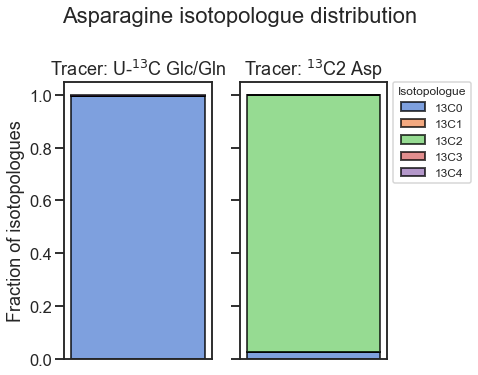

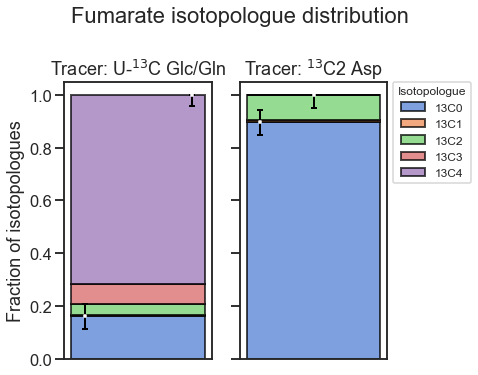

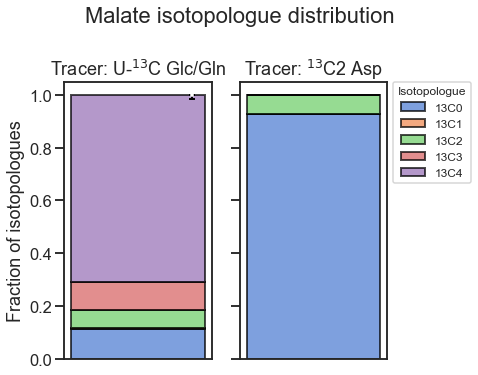

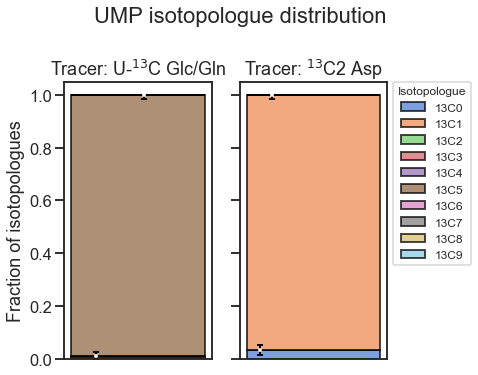

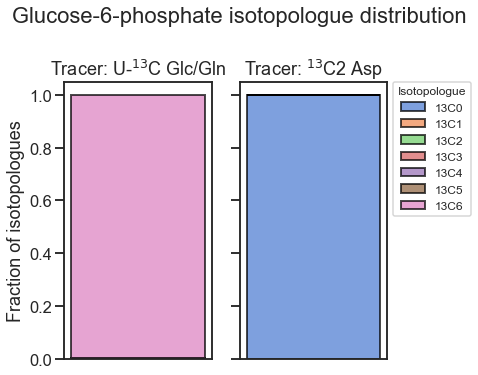

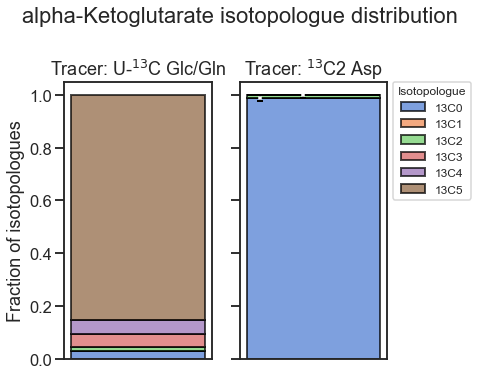

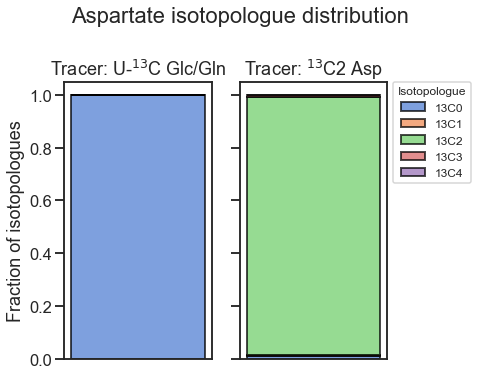

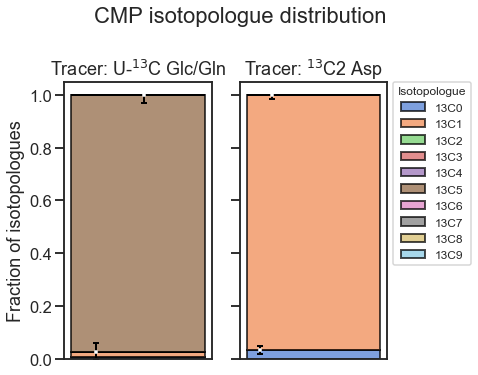

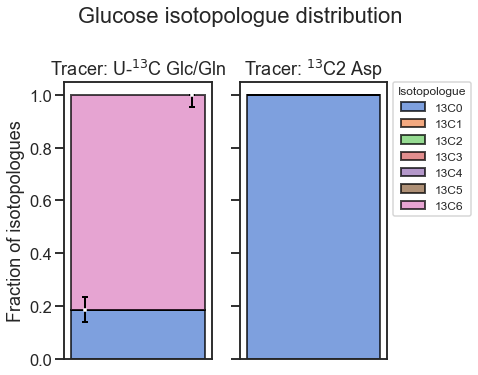

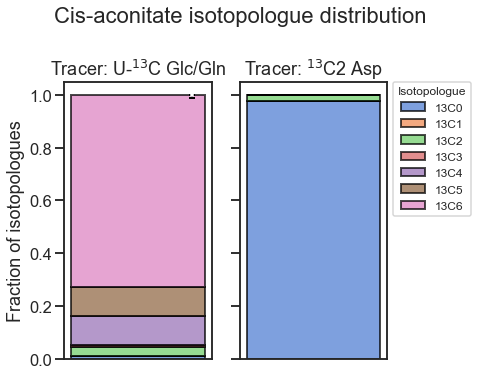

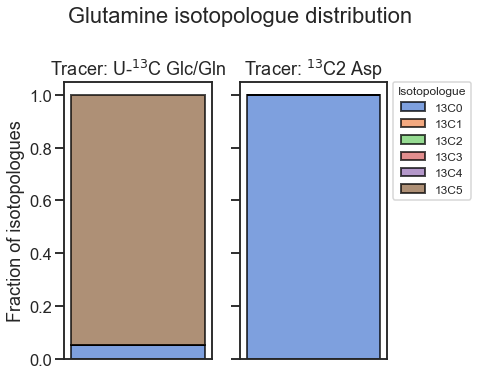

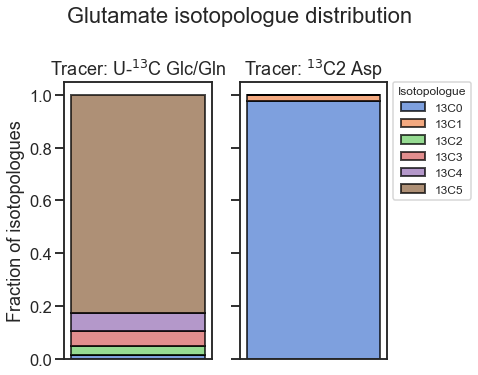

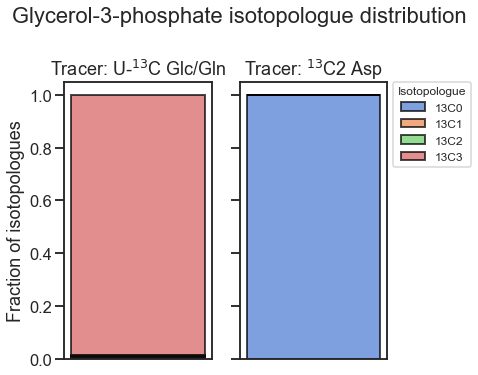

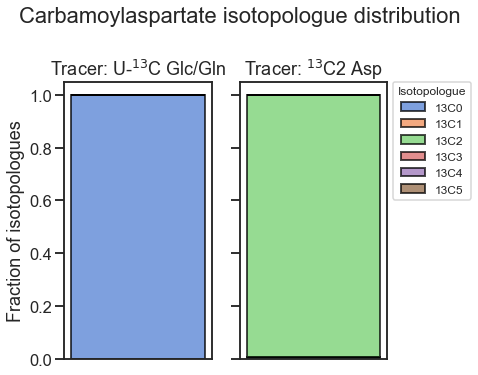

In [16]:
### Plot isotopologue distribution ###

labels = ['13C2-Asp', 'U13C-Glc-Gln']
tracer_list = ['U13C-Glc-Gln', '13C2-Asp']
tracer_list_name = ['U-$^{13}$C Glc/Gln', '$^{13}$C2 Asp']

width = 1           # the width of the bars


for base in list(set(metab_names_mes)):
    Nplots = 0
    for tracer in tracer_list:
        mask = metab_dict_mes_mean[base]['Tracer'] == tracer
        if metab_dict_mes_mean[base][mask]['Isotope_fraction'].sum() > 0:
            Nplots += 1
    if Nplots == 1:
        fig, ax = plt.subplots(1, 1, figsize=(5.1, 5.4), sharey=True)
        ax_list = [ax]
    else:
        fig, ax_list = plt.subplots(1, 2, figsize=(7, 5.4), sharey=True)
    
    ax_idx = 0
    for tracer_idx, tracer in enumerate(tracer_list):
        plot_objs = []
        mask = metab_dict_mes_mean[base]['Tracer'] == tracer
        # Sorting makes sure that #7 comes before #10. 
        df_tmp = metab_dict_mes_mean[base][mask]
        if df_tmp['Isotope_fraction'].sum() == 0:
            continue
        df_tmp_stdev = metab_dict_mes_stdev[base][mask]
        area_sum = np.zeros(1)
        isotope_name_list = sorted(list(set(df_tmp['Isotope'].values)), key=lambda x: int(x[3:]))
        Niso = len(isotope_name_list)
        err_space = 0.8/(Niso-1)
        for i, isotope in enumerate(isotope_name_list):
            iso_mask = df_tmp['Isotope'] == isotope
            isotope_fraction_list = df_tmp[iso_mask]['Isotope_fraction'].values
            #### Determine error bar ####
            yerr_1N = df_tmp_stdev[iso_mask]['Isotope_fraction'].values
            yerr_low = list()
            yerr_high = list()
            for err_i, yerr in enumerate(yerr_1N):
                yerr_new = list()
                bar_height = isotope_fraction_list[err_i] + area_sum[err_i]
                # No errorbar smaller than 0:
                if (bar_height - yerr) < 0:
                    yerr_low.append(bar_height)
                else:
                    yerr_low.append(yerr)
                # No errorbar larger than 1:
                if (yerr + bar_height) > 1:
                    yerr_high.append(1 - bar_height)
                else:
                    yerr_high.append(yerr)
            yerr_2N = [yerr_low, yerr_high]
            #############
            
            p = ax_list[ax_idx].bar(0, isotope_fraction_list, width, bottom=area_sum, color=palette[i], edgecolor='black', linewidth=2, alpha=0.7)
            plot_objs.append(p)
            area_sum += isotope_fraction_list
            # Shift errorbar on x-axis:
            err_x = -0.4 + i * err_space
            for dot_idx, (err_l, err_h) in enumerate(zip(*yerr_2N)):
                # Only plot errorbar and dot if more than 1% error:
                if max([err_l, err_h])  > 0.01:
                    errbar_dots = ax_list[ax_idx].scatter(err_x, area_sum[dot_idx], s=8, marker='s', c='white', zorder=999)
                    errbar = ax_list[ax_idx].errorbar(err_x, area_sum[dot_idx], yerr=[[err_l],[err_h]], xerr=None, ecolor='black', lw=2, capsize=3, capthick=2, ls='none')


        ax_list[ax_idx].set_ylim([0, 1.05])
        ax_list[ax_idx].set_xticks([])
        ax_list[ax_idx].set_title('Tracer: {}'.format(tracer_list_name[tracer_idx]))
        if ax_idx == 0:
            ax_list[ax_idx].set_ylabel('Fraction of isotopologues')
        ax_idx += 1
    
    ax_list[ax_idx-1].legend([p[0] for p in plot_objs], list(map(str, isotope_name_list)), loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, fontsize=12, title='Isotopologue', title_fontsize=12)

    if Nplots == 1:
        fig.suptitle('{}\nisotopologue distribution'.format(base), size=22)
    else:
        fig.suptitle('{} isotopologue distribution'.format(base), size=22)
    plt.tight_layout()
    plt.savefig('plots/{}_isotopologue_distribution.pdf'.format(base))
    plt.show();